In [2]:
import os
import sys
import re
import time
import random
import warnings
import collections
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# sys.path.append('../src')
# import cb_utils

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

### Modelling

In [3]:
from fastai.text.all import *

In [4]:
path = Path('../')

In [5]:
folder = 'service_type_cpt_icds'

In [6]:
files = get_text_files(path, folders = [folder])

In [7]:
len(files)

291076

In [8]:
txts = L(o.open().read().split(' ') for o in files)

In [9]:
len(txts)

291076

In [10]:
lens = [len(t) for t in txts]

In [11]:
np.mean(lens), np.median(lens), np.max(lens), np.min(lens)

(811.2318604075912, 288.0, 63946, 3)

In [12]:
counter = Counter(tok for pat in txts for tok in set(pat))

In [13]:
vocab = make_vocab(counter, min_freq=20)

In [14]:
len(vocab)

18080

In [15]:
dls = TextDataLoaders.from_folder(
    path / folder,
    valid_pct=.1,
    seed=None,
    text_vocab=vocab,
    is_lm=True,
    tok_tfm=None,
    seq_len=72,
    backwards=False,
    bs=64,
    val_bs=None,
    shuffle=True,
    device=None
)

In [18]:
model_root_name = 'st_cpt_icd_model_20220925'
learn = language_model_learner(
    dls=dls,
    arch=AWD_LSTM,
    drop_mult=1,
    pretrained=False,
    cbs=[
        EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=4),
        SaveModelCallback(monitor='valid_loss',fname=model_root_name)
    ],
    metrics=[accuracy, Perplexity()]).to_fp16()

In [17]:
dls.show_batch(max_n=2)

,text,text_
0,xxbos st_11 xxunk xxrep xxunk xxunk icd_f459 icd_i10 icd_m6281 icd_r1310 icd_r41841 icd_z931 ttlc_1 st_8 cpt_99310 icd_f44 icd_i10 icd_m6281 icd_z931 ttlc_1 st_8 cpt_90792 icd_f44 icd_f459 ttlc_1 st_8 cpt_99309 icd_f419 icd_f44 icd_i10 icd_r52 xxunk xxrep xxunk xxunk icd_f459 icd_i10 icd_m6281 icd_r1310 icd_r41841 icd_z931 ttlc_5 st_8 cpt_99309 icd_d649 icd_f44 icd_r52 icd_z931 ttlc_5 st_8 cpt_99309 icd_f419 icd_f44 icd_r52 ttlc_5 st_8 cpt_99307 icd_d649 icd_f419 icd_f44 icd_i10 ttlc_1 st_8 cpt_99310 icd_f44 icd_f459 ttlc_1 st_8 cpt_99307 icd_d649 icd_f419 icd_f44,st_11 xxunk xxrep xxunk xxunk icd_f459 icd_i10 icd_m6281 icd_r1310 icd_r41841 icd_z931 ttlc_1 st_8 cpt_99310 icd_f44 icd_i10 icd_m6281 icd_z931 ttlc_1 st_8 cpt_90792 icd_f44 icd_f459 ttlc_1 st_8 cpt_99309 icd_f419 icd_f44 icd_i10 icd_r52 xxunk xxrep xxunk xxunk icd_f459 icd_i10 icd_m6281 icd_r1310 icd_r41841 icd_z931 ttlc_5 st_8 cpt_99309 icd_d649 icd_f44 icd_r52 icd_z931 ttlc_5 st_8 cpt_99309 icd_f419 icd_f44 icd_r52 ttlc_5 st_8 cpt_99307 icd_d649 icd_f419 icd_f44 icd_i10 ttlc_1 st_8 cpt_99310 icd_f44 icd_f459 ttlc_1 st_8 cpt_99307 icd_d649 icd_f419 icd_f44 icd_r1310
1,icd_r110 xxunk xxrep xxunk xxunk xxunk icd_z992 cpt_q4081 icd_d509 icd_d631 icd_n186 icd_r110 xxunk xxrep xxunk xxunk xxunk icd_z992 cpt_q4081 icd_d509 icd_d631 icd_n186 icd_r110 xxunk xxrep xxunk xxunk xxunk icd_z992 cpt_j1756 icd_d509 icd_d631 icd_n186 icd_r110 xxunk xxrep xxunk xxunk xxunk icd_z992 cpt_j2405 icd_d509 icd_d631 icd_n186 icd_r110 xxunk xxrep xxunk xxunk xxunk icd_z992 xxunk xxrep xxunk xxunk icd_d509 icd_d631 icd_n186 icd_r110 xxunk xxrep xxunk xxunk xxunk icd_z992 cpt_85041 icd_d509 icd_d631 icd_n186 icd_r110 xxunk xxrep,xxunk xxrep xxunk xxunk xxunk icd_z992 cpt_q4081 icd_d509 icd_d631 icd_n186 icd_r110 xxunk xxrep xxunk xxunk xxunk icd_z992 cpt_q4081 icd_d509 icd_d631 icd_n186 icd_r110 xxunk xxrep xxunk xxunk xxunk icd_z992 cpt_j1756 icd_d509 icd_d631 icd_n186 icd_r110 xxunk xxrep xxunk xxunk xxunk icd_z992 cpt_j2405 icd_d509 icd_d631 icd_n186 icd_r110 xxunk xxrep xxunk xxunk xxunk icd_z992 xxunk xxrep xxunk xxunk icd_d509 icd_d631 icd_n186 icd_r110 xxunk xxrep xxunk xxunk xxunk icd_z992 cpt_85041 icd_d509 icd_d631 icd_n186 icd_r110 xxunk xxrep xxunk


In [18]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(18080, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(18080, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=18080, bias=True)
    (output_dp): RNNDropout()
  )
)

/home/bp/.local/share/virtualenvs/data-analytics-qWXImv-u/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.00019054606673307717)

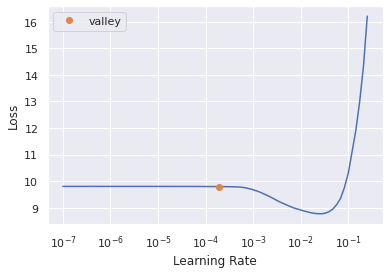

In [19]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(10, 10e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.419806,1.442616,0.713581,4.231753,3:02:17
1,1.260208,1.181609,0.749618,3.259614,3:03:26
2,1.196050,1.098858,0.761815,3.000738,3:00:51
3,1.105927,1.057861,0.768935,2.880205,3:00:53
4,1.064132,1.026587,0.774571,2.791522,3:05:57
5,1.100780,0.993935,0.779791,2.701846,3:00:33
6,1.078079,0.965501,0.784944,2.626102,3:00:30
7,1.003354,0.944411,0.788343,2.571299,3:00:45
8,1.032681,0.930384,0.790787,2.535482,3:00:39
9,1.020864,0.926789,0.791473,2.526383,3:01:40


Better model found at epoch 0 with valid_loss value: 1.4426164627075195.
Better model found at epoch 1 with valid_loss value: 1.1816089153289795.
Better model found at epoch 2 with valid_loss value: 1.0988582372665405.
Better model found at epoch 3 with valid_loss value: 1.0578614473342896.
Better model found at epoch 4 with valid_loss value: 1.0265870094299316.
Better model found at epoch 5 with valid_loss value: 0.9939353466033936.
Better model found at epoch 6 with valid_loss value: 0.9655006527900696.
Better model found at epoch 7 with valid_loss value: 0.9444111585617065.
Better model found at epoch 8 with valid_loss value: 0.9303838610649109.
Better model found at epoch 9 with valid_loss value: 0.9267885684967041.


### Save model, encoder, and vocab

In [22]:
models_path = '/home/bp/data-analytics/models/'
file = models_path + model_root_name
file

'/home/bp/data-analytics/models/st_cpt_icd_model_20221006'

In [23]:
learn.save(file, with_opt=True, pickle_protocol=2)

Path('/home/bp/data-analytics/models/st_cpt_icd_model_20221006.pth')

In [24]:
file = models_path + 'enc_' + model_root_name
learn.save_encoder(file)

In [25]:
file

'/home/bp/data-analytics/models/enc_st_cpt_icd_model_20221006'

In [26]:
vocab_path = models_path + 'vocab_' + model_root_name
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
vocab_path

'/home/bp/data-analytics/models/vocab_st_cpt_icd_model_20221006'

### Visualize Results

In [ ]:
learn.model

In [ ]:
# with open('jsonb_object_agg_ndcoprietary_name___json.json', 'rb') as f:
#     ndc_lookup = json.load(f)
#     ndc_lookup = ndc_lookup[0]['jsonb_object_agg']
# with open('ndc_lookup.json', 'wb') as f:
#     pickle.dump(ndc_lookup, f)
with open('ndc_lookup.json', 'rb') as f:
    ndc_lookup = pickle.load(f)
ndc_lookup['00904643480']

In [27]:
from torch.nn import functional as F

def get_normalized_embeddings():
    return F.normalize(learn.model[0].encoder.weight)

def most_similar(token, embs):
    if token[:2] == 'xx':
        return
#     idx = num.vocab.itos.index(token)
    idx = vocab.index(token)
    sims = (embs[idx] @ embs.t()).cpu().detach().numpy()

    print(f'Similar to: {token}')
    for sim_idx in np.argsort(sims)[::-1][1:11]:
        if vocab[sim_idx][:2] == 'xx':
            print(f'{sims[sim_idx]:.02f}: {vocab[sim_idx]}')
        else:
            print(f'{sims[sim_idx]:.02f}: {vocab[sim_idx]}: {vocab[sim_idx]}')
            

In [28]:
embeddings = get_normalized_embeddings()

In [82]:
for code in random.sample(vocab, 10):
    most_similar(code, embeddings)
    print('')
most_similar('st_8', embeddings)

Similar to: icd_z85028
0.99: icd_s20419a: icd_s20419a
0.99: icd_z8615: icd_z8615
0.99: icd_y833: icd_y833
0.99: icd_t380x6s: icd_t380x6s
0.99: icd_z531: icd_z531
0.99: icd_q632: icd_q632
0.99: icd_r826: icd_r826
0.99: icd_x102xxa: icd_x102xxa
0.99: icd_s2249xs: icd_s2249xs
0.99: icd_t1592xa: icd_t1592xa

Similar to: icd_m1711
0.99: icd_m170: icd_m170
0.99: icd_m25561: icd_m25561
0.99: icd_m1712: icd_m1712
0.98: icd_m19011: icd_m19011
0.98: icd_m47812: icd_m47812
0.98: icd_m1612: icd_m1612
0.98: icd_m48061: icd_m48061
0.98: icd_m25562: icd_m25562
0.98: icd_m25512: icd_m25512
0.98: icd_m5416: icd_m5416

Similar to: cpt_g2089
1.00: cpt_g2181: cpt_g2181
1.00: cpt_g9691: cpt_g9691
1.00: cpt_99473: cpt_99473
1.00: cpt_g9510: cpt_g9510
1.00: cpt_4064f: cpt_4064f
1.00: cpt_3025f: cpt_3025f
1.00: cpt_g2104: cpt_g2104
1.00: cpt_4001f: cpt_4001f
1.00: cpt_g9459: cpt_g9459
1.00: cpt_3354f: cpt_3354f

Similar to: cpt_45990
1.00: cpt_46270: cpt_46270
1.00: cpt_45100: cpt_45100
1.00: cpt_45915: cpt_4

In [81]:
vocab[10]

'st_8'

### Get embeddings for 2020 uhc tx

In [74]:
df = pd.read_csv('data/year_level_targets_20221010.csv')
df.head()

,mco_id,member_id,yr,ip_tc,ip_er_tc,ip_ddos_span
0,2,1,2017,0.00,0.00,0
1,2,1,2018,0.00,0.00,0
2,2,1,2019,11429.58,11766.19,56
3,2,1,2020,0.00,0.00,0
4,2,1,2021,0.00,825.41,0


In [64]:
def is_2020(f):
    match = re.match('^\d*_(.*).0_\d*\.txt$', f.name)
    return match.groups()[0] == '2020'

twentytwenty_files = [f for f in files if is_2020(f)]

In [65]:
len(twentytwenty_files)

66038

In [40]:
os.path.basename(files[0])

'7_2019.0_307714.txt'

In [48]:
f = uhc_tx_files[0]
print(f.name)
match = re.match('^\d*_\d*.0_(.*)\.txt$', f.name)
match.groups()[0]

5_2020.0_252669.txt


'252669'

In [77]:
import shutil
for f in tqdm(files):
    match = re.match('\d*_\d*.0_(.*)\.txt$', f.name)
    if match is None:
        break
    mem = df.loc[df.member_id== int(match.groups()[0])]
    
    if mem.shape[0]:
        new_file_name = f'{mem.member_id.values[0]}_{int(mem.ip_er_tc.values[0])}_{mem.ip_ddos_span.values[0]}.txt'
        shutil.copyfile(f, '../service_type_cpt_icds_target/'+new_file_name)
        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 291076/291076 [04:31<00:00, 1070.61it/s]


In [75]:
df.describe()

,mco_id,member_id,yr,ip_tc,ip_er_tc,ip_ddos_span
count,301609.000000,3.016090e+05,301609.000000,3.016090e+05,3.016090e+05,301609.000000
mean,5.996257,4.132913e+05,2019.944673,4.219352e+03,4.976447e+03,95.256123
std,3.709013,3.754492e+05,1.344316,1.756113e+04,1.829776e+04,507.078146
min,2.000000,1.000000e+00,2017.000000,0.000000e+00,0.000000e+00,0.000000
25%,3.000000,7.045900e+04,2019.000000,0.000000e+00,0.000000e+00,0.000000
50%,5.000000,2.663880e+05,2020.000000,0.000000e+00,0.000000e+00,0.000000
75%,7.000000,9.745660e+05,2021.000000,0.000000e+00,1.430110e+03,0.000000
max,13.000000,1.017277e+06,2022.000000,1.991467e+06,1.993278e+06,54575.000000


### Create patient embeddings

In [134]:
embeddings = get_normalized_embeddings()

results = []

for file in files[:10000]:
    with open(file, 'r') as f:
        text = f.read()
    text = 'xxbos' + text
    embs = [embeddings[vocab.index(e)] for e in text.split(' ') if e in vocab]
    final = None
    for e in embs:
        if final is None:
            final = e
        else:
            final += e
    results.append((file.name, final.tolist()))

In [135]:
df = pd.DataFrame(results, columns=['file_name', 'emb'])

In [136]:
df.head()

,file_name,emb
0,7_2019.0_307714.txt,"[0.9682520031929016, -0.28859424591064453, -0.20893384516239166, -0.29513609409332275, -0.39483708143234253, -0.206153005361557, 0.008076181635260582, -0.5558689832687378, -1.813232660293579, -18.255184173583984, -0.24172648787498474, 0.009930707514286041, 0.7637577056884766, 0.08024761080741882, 0.48981472849845886, 1.5854743719100952, 0.8164970874786377, 0.0791264995932579, -0.19146890938282013, 17.859359741210938, 0.28612056374549866, 0.2958122193813324, -3.8960041999816895, -0.38603708148002625, -4.379040241241455, 0.44293704628944397, -6.408330917358398, 0.17267541587352753, 0.0827256..."
1,7_2020.0_287080.txt,"[18.310993194580078, 1.6892184019088745, -7.697311878204346, -11.328058242797852, -5.505013942718506, -6.491467475891113, -5.7679009437561035, -9.527252197265625, -34.2703857421875, -317.95159912109375, -2.354614019393921, 2.5501978397369385, 8.778717994689941, -1.1028919219970703, 7.978809833526611, 32.4781379699707, -2.6543774604797363, 5.5189714431762695, 3.7883145809173584, 301.9561462402344, -2.0958921909332275, 1.301592469215393, -101.77124786376953, -10.065933227539062, -82.39390563964844, -0.8393005728721619, -131.99044799804688, 8.021485328674316, -0.6219528317451477, -163.9066467..."
2,12_2020.0_980201.txt,"[18.689212799072266, 1.7114108800888062, -7.914021015167236, -11.528873443603516, -5.799994945526123, -6.427154541015625, -5.840792179107666, -9.601716995239258, -35.07278060913086, -325.05999755859375, -2.364914655685425, 2.6401917934417725, 9.066614151000977, -1.1253445148468018, 8.174783706665039, 33.35862350463867, -2.728717565536499, 5.618748188018799, 3.7169768810272217, 308.21209716796875, -2.1297388076782227, 1.3620835542678833, -104.00867462158203, -10.340047836303711, -84.0798568725586, -0.8814522624015808, -134.87042236328125, 7.989661693572998, -0.5254107117652893, -167.21875, ..."
3,8_2021.0_301342.txt,"[19.71872901916504, 2.369621992111206, -8.717247009277344, -11.938640594482422, -6.481914520263672, -6.572677135467529, -6.010908126831055, -9.753923416137695, -38.412696838378906, -354.4949645996094, -2.686272382736206, 2.573132276535034, 9.73313045501709, -1.2908594608306885, 9.174948692321777, 37.08787536621094, -2.6578519344329834, 5.779391765594482, 3.913917064666748, 334.0244140625, -2.0172884464263916, 2.127295970916748, -112.96170043945312, -10.850388526916504, -91.64517974853516, -1.4090855121612549, -146.6513214111328, 7.917776107788086, -0.45733529329299927, -180.83786010742188,..."
4,5_2019.0_268134.txt,"[44.026573181152344, -1.1430140733718872, -21.884050369262695, -20.341066360473633, -15.54665470123291, -12.123716354370117, -9.65243911743164, -22.64624786376953, -107.92884063720703, -912.3770141601562, -9.322630882263184, 12.807621002197266, 28.52823829650879, -7.50709342956543, 23.166584014892578, 110.35092163085938, -4.21934700012207, 6.8746185302734375, 13.466535568237305, 947.9166259765625, -3.2824487686157227, 12.827987670898438, -312.7812194824219, -20.605215072631836, -256.9577941894531, -1.5255781412124634, -397.7538146972656, 13.967757225036621, 0.5071383118629456, -473.6279602..."


In [167]:
df.file_name.str.split('_', expand=True)

,0,1,2
0,7,2019.0,307714.txt
1,7,2020.0,287080.txt
2,12,2020.0,980201.txt
3,8,2021.0,301342.txt
4,5,2019.0,268134.txt
...,...,...,...
9995,2,2018.0,6770.txt
9996,2,2021.0,28653.txt
9997,8,2019.0,303297.txt
9998,2,2019.0,902.txt


In [145]:
from sklearn.manifold import TSNE
X = np.array([np.array(x) for x in df.emb.values])

In [144]:
X.shape

(10000, 400)

In [147]:
X[1].shape

(400,)

In [162]:
from sklearn.decomposition import PCA
X_embedded = TSNE(n_components=2).fit_transform(X)

In [163]:
X.shape, X_embedded.shape

((10000, 400), (10000, 2))

In [164]:
X_embedded[9999]

array([88.1168  , 29.870747], dtype=float32)

In [165]:
df = df.assign(x=X_embedded[:,0], y=X_embedded[:, 1])

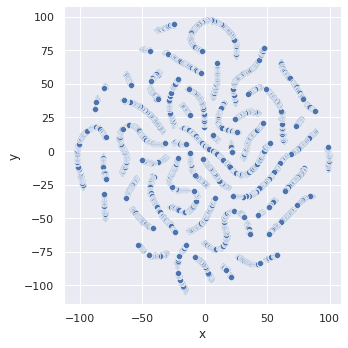

In [166]:
sns.relplot(data=df, x='x', y='y')